# <font color='violet'> Modeling to Predict Ratings based on Reviews 
    
Using data with most features engineered here: https://github.com/fractaldatalearning/psychedelic_efficacy/blob/main/notebooks/6-kl-studies-finish-preprocess.ipynb

Other feature engineering will be completed as part of the modeling pipeline. 

In [1]:
# ! pip install xgboost

In [31]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, balanced_accuracy_score, log_loss, f1_score 
from sklearn.metrics import top_k_accuracy_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier

import seaborn as sns
import pickle

from IPython.display import Audio
sound_file = './alert.wav'

In [3]:
df = pd.read_csv('../data/processed/studies_w_vector_similarity.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31557 entries, 0 to 31556
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         31557 non-null  int64  
 1   condition          31557 non-null  object 
 2   date               31557 non-null  object 
 3   drug0              31557 non-null  object 
 4   drug1              31557 non-null  object 
 5   review_len         31557 non-null  int64  
 6   complexity         31557 non-null  float64
 7   no_stop_cap_lemm   31557 non-null  object 
 8   subjectivity       31557 non-null  float64
 9   original_polarity  31557 non-null  float64
 10  set                31557 non-null  object 
 11  rating             31557 non-null  float64
 12  similarity_w_10    31557 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 3.1+ MB


In [4]:
# Remove categorical features that aren't specifically related to the review text
df = df.drop(columns = ['Unnamed: 0', 'condition', 'date', 'drug0', 'drug1'])

# Rename the review column for clarity.
df = df.rename(columns={'no_stop_cap_lemm':'review'})

# Reorder columns for clarity
df = df[['review', 'rating', 'review_len', 'complexity', 'subjectivity', 
              'original_polarity', 'similarity_w_10', 'set']]

df.head()

,review,rating,review_len,complexity,subjectivity,original_polarity,similarity_w_10,set
0,good give run gas,9.0,36,-1.2,0.600000,0.700000,0.640050,train
1,75 mg x daily no noticeable effect 150 mg x da...,8.0,547,5.4,0.343056,0.031439,0.841263,train
2,take 145 mg 10 year fantastic insomnia really ...,8.0,390,4.8,0.591667,0.096296,0.922576,train
3,help stability mood help insomnia start experi...,7.0,156,8.2,1.000000,-1.000000,0.825203,train
4,crazy eat sleep sit,2.0,66,-0.4,0.900000,-0.600000,0.467668,train


There are going to be a bunch of moving parts once I get to the gridsearch. I'd like to take care of anything I can in advance rather than including normalization in the pipeline. 

<font color='violet'> Normalize numerical dependent variables prior to moving on

In [5]:
# Normalize numeric dependent variables prior to moving on. 
mms = MinMaxScaler()
df[['review_len', 'complexity', 'subjectivity', 'original_polarity', 
    'similarity_w_10']] = mms.fit_transform(df[['review_len', 'complexity', 'subjectivity', 
                                                'original_polarity', 'similarity_w_10']])

df.head()

,review,rating,review_len,complexity,subjectivity,original_polarity,similarity_w_10,set
0,good give run gas,9.0,0.004525,0.034848,0.600000,0.850000,0.681421,train
1,75 mg x daily no noticeable effect 150 mg x da...,8.0,0.087104,0.134848,0.343056,0.515720,0.867294,train
2,take 145 mg 10 year fantastic insomnia really ...,8.0,0.061732,0.125758,0.591667,0.548148,0.942408,train
3,help stability mood help insomnia start experi...,7.0,0.023917,0.177273,1.000000,0.000000,0.852459,train
4,crazy eat sleep sit,2.0,0.009373,0.046970,0.900000,0.200000,0.522181,train


It will be simpler going forward to return a smaller number of ratings, and my guess is that the model will perform better with fewer categories to choose among. 
<font color='violet'> Change ratings from 1-10 to 0-4 

In [6]:
df['rating'] = df.rating.replace({1:0,2:0,3:1,4:1,5:2,6:2,7:3,8:3,9:4,10:4})
df['rating'] = LabelEncoder().fit_transform(df.rating)
df.rating.unique()

array([4, 3, 0, 1, 2])

In [7]:
# Recreate train-test sets
train_set = df[df.set=='train'].drop(columns=['set']).copy()
test_set = df[df.set=='test'].drop(columns=['set']).copy()

train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22089 entries, 0 to 22088
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review             22089 non-null  object 
 1   rating             22089 non-null  int64  
 2   review_len         22089 non-null  float64
 3   complexity         22089 non-null  float64
 4   subjectivity       22089 non-null  float64
 5   original_polarity  22089 non-null  float64
 6   similarity_w_10    22089 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.3+ MB


In [8]:
X_train = train_set.drop(columns=['rating'])
X_test = test_set.drop(columns=['rating'])
y_train = train_set.rating
y_test = test_set.rating

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22089 entries, 0 to 22088
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review             22089 non-null  object 
 1   review_len         22089 non-null  float64
 2   complexity         22089 non-null  float64
 3   subjectivity       22089 non-null  float64
 4   original_polarity  22089 non-null  float64
 5   similarity_w_10    22089 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.2+ MB


<font color='violet'> Find accuracy for a naive model
    
I know I won't want to use accuracy that comes default with dummy.score, so try scoring with some more relevant metrics and ones that work with a multiclass target variable.

In [9]:
dummy = DummyClassifier(strategy='stratified', random_state=17)
dummy.fit(X_train, y_train)
strat_dummy_pred = dummy.predict(X_test)
balanced_accuracy_score(strat_dummy_pred, y_test)

0.19941112547038012

In [10]:
dummy = DummyClassifier(strategy='most_frequent', random_state=17)
dummy.fit(X_train, y_train)
freq_dummy_pred = dummy.predict(X_test)
balanced_accuracy_score(freq_dummy_pred, y_test)

/Users/admin/opt/anaconda3/envs/psychedelic_efficacy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.536227291930714

Even using balanced_accuracy, which is just the average recall, performance of a naive model is higher when all values are set to "most frequent" because classes are imbalanced, with most ratings being 10 (or, actually, now the highest score is 9). I'll want to narrow in on precision and recall as usual when evaluating models, and, better, find some way to make roc_auc and log_loss work with this multiclass problem. 

It's not totally clear to me from the documentation which metrics work well for scoring multiclass classification, try some out here. Use strategy='most_frequent' in the dummy classifier because eventually I want my model to outperform the best-performing naive model (all values set to a perfect rating).

In [11]:
freq_dummy_pred

array([4, 4, 4, ..., 4, 4, 4])

In [12]:
dummy = DummyClassifier(strategy='most_frequent', random_state=17)
dummy.fit(X_train, y_train)
freq_dummy_prob = dummy.predict_proba(X_test)

log_loss(y_test, freq_dummy_prob)

16.71606274098156

Log loss requires predict_proba rather than predict, to produce an array for each prediction of the probability that it matches each rating. 

neg_log_loss (log loss but negative, so that a greater value is better, like the rest of the gridsearch scorers) could be a solid scorer for the gridsearch. Check out a few more, though. 

In [13]:
recall_score(y_test, freq_dummy_pred, average='micro')

0.536227291930714

In [14]:
f1_score(y_test, freq_dummy_pred, average='micro')

0.536227291930714

In [15]:
f1_score(y_test, freq_dummy_pred, average='macro')

0.13962186318322445

In [16]:
f1_score(y_test, freq_dummy_pred, average='weighted')

0.37434526794530554

In [17]:
top_k_accuracy_score(y_test, freq_dummy_prob, k=1)

0.536227291930714

Unsurprisingly, balanced_accuracy, recall, f1 with average=micro, and top_k_accuracy_score with k=1 all have the same result. I could include one of them as a scorer in gridsearch. 

Finally, try out roc_auc

In [18]:
roc_auc_score(y_test, freq_dummy_prob, average='weighted', multi_class='ovr')

0.5

roc_auc was 0.5 as expected

Create a pipeline in order to gridsearch and tune hyperparameters. Include PCA and CountVectorizer in a column transformer and tune their hyperparameters as well. 

As far as I can tell, there are no missing values in this data currently, but the gridsearch is raising an error that some of the estimators don't work because there are missing values, so  one of my transformers must be introducing missingness. I wouldn't expect pca or countvectorizer to create NaN values (my understanding is that the sparse matrix created by a countvectorizer is full of zeros, not NaNs). But add imputers to pipelines after transformation to make sure. 

Re: transformer hyperparameters: I found during preprocessing that 1,2,3 or all features might be meaningful. For CountVectorizer, counting character combinations might actually make the model work better on unseen data. I don't actually want character 1grams or word 3grams; change later if those come out on top. Hyperparameters around min and max occurrance could be set, but I actually just want all words present here to be included in the model. It could make it perform a bit less well, but my operating assumption is that this will make it more likely to share words in common with unseen data. 

<font color='violet'> Conduct initial random grid search

In [19]:
%%time

# Make variables for types of columns & instantiate what to do with each 
review_col = 'review'
numeric_cols = ['review_len', 'complexity', 'subjectivity', 'original_polarity', 
                'similarity_w_10']


num_trans = Pipeline(steps=[('pca', PCA(random_state=17)), ('mms', MinMaxScaler()), 
                            ('si', SimpleImputer())])
text_trans = Pipeline(steps=[('cv', CountVectorizer(lowercase=False)), 
                             ('si', SimpleImputer())])

# Build column transformer
cols = ColumnTransformer([('num', num_trans, numeric_cols), 
                          ('text', text_trans, review_col)])

# Create parameters for PCA, CountVectorizer
pca_cv = {'cols__num__pca__n_components':[1,2,3,5], 
              'cols__text__cv__ngram_range':[(1,1), (1,2), (1,3)], 
              'cols__text__cv__analyzer':['word', 'char']}


# List potential parameters for each classifier
# Use SVC with OneVsRest and bagging to speed it up. kernel=linear for speed just for now. 
svc_params = {'clf':(OneVsRestClassifier(estimator=BaggingClassifier(
    estimator=SVC(probability=True, random_state=17, kernel='linear'), 
    max_samples=0.05, bootstrap=False, n_jobs=-1, n_estimators=1)),), 
              'clf__estimator__estimator__C':list(np.arange(1,11)), 
              'clf__estimator__estimator__degree':list(np.arange(1,11)), 
              'clf__estimator__estimator__gamma':['scale', 'auto'], 
              'clf__estimator__estimator__coef0':list(np.arange(0,4,0.5)), 
              'clf__estimator__estimator__shrinking':[True,False], 
              'clf__estimator__estimator__probability':[True,False], 
              'clf__estimator__estimator__class_weight':[None,'balanced']}
svc_params.update(pca_cv)

# ComplementNB is a beysian classifier I read is good for text & imbalanced classes
cnb_params = {'clf':(ComplementNB(),), 'clf__alpha':[0.01, 0.1, 0.5, 1, 2, 5, 10]}
cnb_params.update(pca_cv)

# Also try MultinomialNB, often used for text classification
mnb_params = {'clf':(MultinomialNB(),), 'clf__alpha':[0.01, 0.1, 0.5, 1, 2, 5, 10], 
              'clf__fit_prior':[True,False]}
mnb_params.update(pca_cv)

# Only select XGB hyperparameters that I've read minimize overfitting, a problem w/ trees
xgb_params = {'clf':(XGBClassifier(),), 'clf__colsample_bytree':list(np.arange(0.1, 0.6, 0.1)), 
              'clf__subsample':list(np.arange(0, 0.6, 0.1)), 
              'clf__max_depth':list(np.arange(1,5)), 'clf__gamma':list(np.arange(4,11,1)), 
              'clf__eta':list(np.arange(0, 0.6, 0.1)), 
              'clf__min_child_weight':[5,20,50,100,200], 'clf__alpha':[5,10,20,50,100], 
              'clf__n_estimators':[5,10,20,50]}
xgb_params.update(pca_cv)

# Prepare scorers
top_k = make_scorer(score_func=top_k_accuracy_score, k=1, needs_proba=True)
scorers = {'top_k':top_k, 'f1':'f1_micro', 'neg_log_loss':'neg_log_loss', 
           'roc_auc':'roc_auc_ovr'}

# Build final pipeline, param grid & instantiate gridsearch
pipe = Pipeline(steps=[('cols', cols), ('clf', DummyClassifier())])
param_grid = [cnb_params, mnb_params, xgb_params, svc_params]

rgs = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, scoring=scorers, 
                         refit='roc_auc', error_score='raise', random_state=4)

# Run the gridsearch
#rgs.fit(X_train, y_train)
#print(rgs.best_params_)
#print(rgs.best_score_)

# Audio(sound_file, autoplay=True)

CPU times: user 326 µs, sys: 147 µs, total: 473 µs
Wall time: 376 µs


After changing the random state and re-running the grid search 5 times, the best classifier was clearly ComplementNB. The specific hyperparameters were:

{'cols__text__cv__ngram_range': (1, 1), 'cols__text__cv__analyzer': 'word', 'cols__num__pca__n_components': 5, 'clf__alpha': 1, 'clf': ComplementNB(alpha=1)}
0.7257045188386937

RidgeClassifier has no predict_proba method, which is a problem for some of the metrics I've chosen above. But, I've heard it can work well with text classiication. So, I'll try out the RidgeClassifier, for comparison with ComplementNB. For simplicity, just try running it with default settings, and minimize column transformation. 

<font color='violet'> Try Ridge

In [20]:
%%time

review_col = 'review'
text_trans = CountVectorizer(lowercase=False)

trans = ColumnTransformer([('text', text_trans, review_col)], remainder='passthrough')
ridge = RidgeClassifier(random_state=17, class_weight='balanced')

pipe = Pipeline(steps=[('trans', trans), ('ridge', ridge)])

#pipe.fit(X_train, y_train)
#ridge_pred = pipe.predict(X_test)
#ridge_score = f1_score(y_test, ridge_pred, average='micro')
#print(ridge_score)

Audio(sound_file, autoplay=True)

CPU times: user 4.44 ms, sys: 2.91 ms, total: 7.35 ms
Wall time: 7.93 ms


The f1 score for Ridge is actually worse than from the DummyClassifier. I'll go with ComplementNB as the final classifier. 

ComplementNB runs so quickly that I could do a comprehensive grid search over at least some of the hyperparameters that could be more finely tuned. All of the results of the original grid search above showed that it's best to do zero reduction on the original features I engineered. So I could just tune hyperparameters of the classifier itself and of CountVectorizer. The SimpleImputer should be unnecessary now, as that was in place, I believe, in order to make SVC function in the randomized gridsearch. 

<font color='violet'> Final GridSearch

In [21]:
%%time

# Remake variables & transformer; include just count vectorizer
# Pass through already-normalized numeric columns. 
review_col = 'review'
text_trans = CountVectorizer(lowercase=False)
trans = ColumnTransformer([('text', text_trans, review_col)], remainder='passthrough')

# Pare down transformer hyperparameters. Combine with estimator hyperparameters.
# Very low alpha values didn't show up in any of the highest-scoring models; drop them. 
params = {'trans__text__ngram_range':[(1,1), (1,2), (1,3)], 
          'trans__text__analyzer':['word', 'char'], 
          'clf__alpha':[0.5, 1, 2, 5, 10]}

# Build the pipeline, and use the same scorers as in the randomized search.
pipe = Pipeline(steps=[('trans', trans), ('clf', ComplementNB())])
scorers = {'top_k':top_k, 'f1':'f1_micro', 'neg_log_loss':'neg_log_loss', 
           'roc_auc':'roc_auc_ovr'}

# Instantiate grid search
gscv = GridSearchCV(estimator=pipe, param_grid=params, scoring=scorers, refit='roc_auc', 
                      return_train_score=True)

# gscv.fit(X_train, y_train)
# print(gscv.best_params_)
# print(gscv.best_score_)

Audio(sound_file, autoplay=True)

{'clf__alpha': 1, 'cols__text__analyzer': 'word', 'cols__text__ngram_range': (1, 1)}
0.7257045188386937
CPU times: user 20min 32s, sys: 1min 12s, total: 21min 45s
Wall time: 22min 22s


In [26]:
# Best params & score: clf alpha=1, cv analyzer=word, ngram=1, 0.7257045188386937

# View all results
results_grid = pd.DataFrame(gscv.cv_results_)
results_grid.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_clf__alpha', 'param_cols__text__analyzer',
       'param_cols__text__ngram_range', 'params', 'split0_test_top_k',
       'split1_test_top_k', 'split2_test_top_k', 'split3_test_top_k',
       'split4_test_top_k', 'mean_test_top_k', 'std_test_top_k',
       'rank_test_top_k', 'split0_train_top_k', 'split1_train_top_k',
       'split2_train_top_k', 'split3_train_top_k', 'split4_train_top_k',
       'mean_train_top_k', 'std_train_top_k', 'split0_test_f1',
       'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1',
       'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_train_f1',
       'split1_train_f1', 'split2_train_f1', 'split3_train_f1',
       'split4_train_f1', 'mean_train_f1', 'std_train_f1',
       'split0_test_neg_log_loss', 'split1_test_neg_log_loss',
       'split2_test_neg_log_loss', 'split3_test_neg_log_loss',
       'split4_test_neg_log_loss', 'mean_test_neg_lo

Just take a look at relevant columns and sort by average log loss. If CountVectorizer with 3gram characters is close in performance to vectorizing with single words, I could explore with larger character ngrams, as that might be more generalizable to new texts. 

In [30]:
results_grid[['param_cols__text__analyzer', 'param_cols__text__ngram_range', 
    'mean_test_neg_log_loss', 'mean_test_roc_auc']].sort_values(
    by='mean_test_neg_log_loss', ascending=False)

,param_cols__text__analyzer,param_cols__text__ngram_range,mean_test_neg_log_loss,mean_test_roc_auc
12,word,"(1, 1)",-1.243849,0.724215
6,word,"(1, 1)",-1.275985,0.725705
0,word,"(1, 1)",-1.319725,0.721097
18,word,"(1, 1)",-1.429642,0.695797
28,char,"(1, 2)",-1.462194,0.674742
22,char,"(1, 2)",-1.485061,0.674779
16,char,"(1, 2)",-1.498351,0.674513
10,char,"(1, 2)",-1.502383,0.674367
4,char,"(1, 2)",-1.504466,0.674222
27,char,"(1, 1)",-1.559398,0.613281


Actually, the highest-scoring model that included character 3grams had a negative log loss of -2.35 and roc_auc of 0.70, compared with word vectorization associated with scores of -1.243849	and 0.724215. These differences are significant enough that it makes me think simple, single word vectorization is the best route to take. 

<font color='violet'> Final Model Evaluation

In [30]:
# The best-performing hyperparameters for ComplementNB were just the defaults.

review_col = 'review'
numeric_cols = ['review_len', 'complexity', 'subjectivity', 'original_polarity', 
                'similarity_w_10']

num_trans = MinMaxScaler()
text_trans = CountVectorizer(lowercase=False)

cols = ColumnTransformer([('num', num_trans, numeric_cols), ('text', text_trans, review_col)])
clf = ComplementNB()

pipe = Pipeline(steps=[('cols', cols), ('clf', clf)])

pipe.fit(X_train, y_train)
proba = pipe.predict_proba(X_test)
pred = pipe.predict(X_test)
print('log loss: ', log_loss(y_test, proba))
print('roc_auc: ', roc_auc_score(y_test, proba, average='weighted', multi_class='ovr'))
print('f1 (or accuracy best k w/ k=1): ', top_k_accuracy_score(y_test, proba, k=1))
print('best k w/ k=2: ', top_k_accuracy_score(y_test, proba, k=2))
print(confusion_matrix(y_test, pred))

log loss:  1.2726915117196869
roc_auc:  0.7518495541863638
f1 (or accuracy best k w/ k=1):  0.5754119138149556
best k w/ k=2:  0.7316223067173637
[[ 864   23   23  167  256]
 [ 231   10   27  131  118]
 [ 216   15   35  210  247]
 [ 301   18   49  586  864]
 [ 387   47   61  629 3953]]


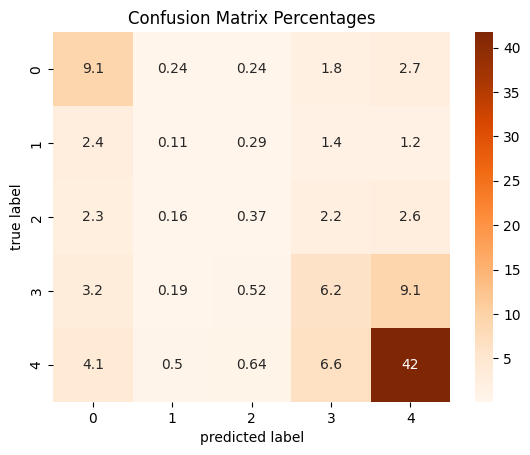

In [41]:
# Print a heatmap to visualize the confusion matrix
cm = confusion_matrix(y_test, pred)
ax = sns.heatmap(data=cm/np.sum(cm)*100, annot=True, cmap='Oranges').set(
    title='Confusion Matrix Percentages', xlabel='predicted label', ylabel='true label')

In [42]:
# Pickle the trained model for later use
with open('../models/trained_model.pkl','wb') as f:
    pickle.dump(pipe,f)

<font color='violet'> Final Hyperparameters and Scores:

Start on data with text data fairly well cleaned and numeric columns already normalized with MinMaxScaler. In a pipeline, first include a ColumnTransformer to transform the text column with CountVectorizer, hyperparameters: lowercase=False and otherwise default (analyzer=word, ngram_range=(1,1)). After thre transformer in the pipeline, include a ComplementNB classifier, default hyperparameters.

Scores:
log loss:  1.2726915117196869
roc_auc:  0.7518495541863638
f1 (or accuracy best k w/ k=1):  0.5754119138149556
best k w/ k=2:  0.7316223067173637
    
Predictably, reviews with a perfect rating were predicted correctly often, since most drugs were given a perfect score. Here's a breakdown of how accurate the model was when taking into account scores that were within one rating i.e. the model predicted a rating of 2 but it was actually 1, 2, or 3:

- When the true label was 0, the model predicted 0 or 1 66% of the time.
- When the true label was 1, the model predicted 0-2 52% of the time.
- When the true label was 2, the model predicted 1-3 38% of the time.
- When the true label was 3, the model predicted 2-4 82% of the time.
- When the true label was 4, the model predicted 3 or 4 90% of the time. 
    
Put another way, here's how inaccurate to expect eventual predictions to be:
- When the model predicted a score of 4, it's correct 73% of the time. It's within one point 89% of the time. 11% of the time, the rating should actually have been 1-3.
- When the model predicts a score of 3, it's correct 34% of the time. It's within one point 82% of the time. 18% of the time, the score should have been a 0-1
- When the model predicts a score of 2, it's correct 18% of the time. It's within 1 point 57% of the time. It should have predicted a score of 0 12% of the time and a score of 4 31% of the time.
- When the model predicts a score of 1, it is correct 9% of the time. It is within 1 point 43% of the time. Over half the time, it should have predicted a score of 3-4.
- When the model predicts a score of 0, it is correct 43% of the time. It is within 1 point 55% of the time, and 45% of the time it should have predicted a rating of 2 or more.  
    

<font color='violet'> Next Steps:

I'd like to come back to this portion of the project (prior notebook and this one) to improve text preprocessing, but for now move on to part two: 
    
Begin scraping the web for psychedelic experience reports so they can be preprocessed to match the format of this data and run through this model. Get started with wrangling here: https://github.com/fractaldatalearning/psychedelic_efficacy/blob/main/scrapy_psychedelic/scrapy_psychedelic/spiders/8-kl-scraping.ipynb
    
    
Note: I drew ideas from these resources: 
- https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a
- https://stackoverflow.com/questions/63467815/how-to-access-columntransformer-elements-in-gridsearchcv